# Домашнее задание 5. Линейные модели

*** Автор --- Ракитин Виталий, BD-11 ***

In [405]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import math
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [406]:
data = np.load("files/out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [407]:
#TRAINING_SET_URL = "twitter_train.txt"
#EXAMPLE_SET_URL = "twitter_example.txt"
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test_submition.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [408]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [409]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x222020) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

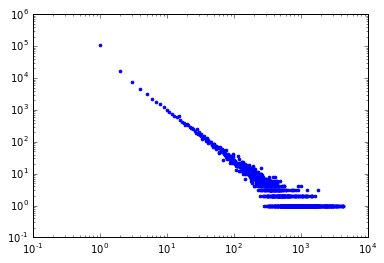

In [410]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    # Your code here
    # нас интересует распределение признаков,имеющих ненулевое значение, по пользователям,
    # поэтому заменим значение каждого признака у каждого пользователя на 1, если он есть,
    # и на 0, если его нет. Так как все значения >= 0, то можно заменить на значение знака,
    # это будет эквивалентно
    word_frequency = np.array(x.sign().sum(0))[0]

    prev_fr = -1
    count = -1
    x1 = []
    y1 = []
    for word_fr in np.sort(word_frequency)[::-1]:
        if word_fr == prev_fr: 
            y1[count] += 1
        elif word_fr != 0:
            x1.append(word_fr)
            y1.append(1)
            prev_fr = word_fr
            count += 1
            
    pl.xscale("log")
    pl.yscale("log")
    pl.scatter(x1,y1,s=7, edgecolor='blue')
    
    return word_frequency
features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [411]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [412]:
USER_NAME = "v.rakitin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2])

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Для начала давайте разберёмся, что вообще это за зверь, и с чем его едят.

У нас есть тренировачный набор данных $N = x_1, \dots, x_m$, где $x_i = x^1,\dots, x^k$, а так же значения целевой функции $y = f(x)$. В нашем случае она может быть равна 0 или 1. 

Мы хотим предсказать вероятность того, что новый вектор параметров $x_j$ будет лежать в классе 1 (или 0), а именно непрерывную переменную со значениями на отрезке [0,1] при любых значениях независимых переменных. Для этого очень удобно использовать логистическая функцию (сигмоиду):

$$p(x_j, \theta) = p(y_j = 1) = \frac{1}{1+e^{-x_j \cdot \theta}}\\
\theta = \{\theta_1, \cdot, \theta_k\} $$

где $\theta$ --- параметры регрессии.

Используем метод максимального правдоподобия, дабы найти значения данного параметра. 

Пусть $P(y_j|x_j,\theta)$ --- вероятность, что при данном значении вектора параметров $x_j$, наши данные лежат в $y_j$ классе. Тогда функция правдоподобия имеет вид:

$$ L(y,x,\theta) = \Pi_j P\left(y_j\big|x_j,\theta\right) \to max\\
 L^* = ln(L) = \sum\limits_{j = 0}^m ln \left(P\left(y_j\big|x_j,\theta\right)\right) \to max\\
 L^* = \sum\limits_{y_j = 1} ln \left(p \left(x_j,\theta \right)\right) + \sum\limits_{y_j = 0} ln \left(p \left(x_j,\theta \right)\right) =\\= \sum\limits_{j = 0}^m \left[y_j ln\left(p \left(x_j,\theta \right)\right) + (1 - y_j)ln\left(1 - p \left(x_j,\theta \right)\right) \right] \to max\\
 $$

Немного преобразуем наш функционал, а так же добавим L2 регуляризацию:

$$ L^{**} = -\frac{1}{m}\sum\limits_{j = 0}^m \left[y_j ln\left(p \left(x_j,\theta \right)\right) + (1 - y_j)ln\left(1 - p \left(x_j,\theta \right)\right) \right] + \frac{\lambda}{2}||\theta||^2 \to min\\$$

Посчитаем градиент (g) и гессиан (H) функции $L^{**}$:

$$g = \frac{1}{m}\sum\limits_{j = 0}^m \left[p \left(x_j,\theta \right) - y_i\right] x_j + \lambda\theta = X^T (\theta - y)\\
H = \frac{1}{m}\sum\limits_{j = 0}^m p \left(x_j,\theta \right) \cdot \left(1 - p \left(x_j,\theta \right)\right) \cdot x_j^Tx_j + \lambda \cdot Id = X^T S X+ \lambda \cdot Id \\
S = diag \left( p \left(x_j,\theta \right) \cdot \left(1 - p \left(x_j,\theta \right)\right)\right)
$$

Минимизируем наш функционал с помощью метода Ньютона:

$$\theta_{i+1} = \theta_i  - H_i^{-1}\cdot g_i\\$$

Реализуем выбранный алгоритм

In [413]:
class LogisticRegression():
    ''' Logistic regression with L2 regularization optimized by Newton method'''
    
    @staticmethod
    def sigmoid(z):
        '''sigmoid function'''
        s =  1.0/(1.0 + math.exp(-z))
        return s

    def fit(self, X, Y=None, lmbd = 0.5):
        self.x = np.array(X)
        self.y = np.array(Y)
        self.N = len(self.x)
        self.Normalization = 1.0/self.N
        self.N_theta = len(self.x[0])
        self.theta = np.ones(self.N_theta)
        self.tol = 0.00001
        self.max_iter = 1000
        self.thr = 0.5
        self.lmbd = lmbd # параметр регуляризации
        self.steps = self.Newton()
        print "Finished studing, made %d steps"%(self.steps)
        return self
    
    def sigmoid_results(self):
        '''Expectation of a class for each x_i'''
        return np.array(map(self.sigmoid,np.dot(self.x,self.theta)))
    
    def S(self):
        p = self.sigmoid_results()
        r = p*(1-p)
        return np.diag(r)
    
    def Gradient(self):
        p = self.sigmoid_results() 
        return self.Normalization * np.dot(self.x.T, p - self.y)  + self.lmbd * self.theta
    
    def Hessian(self):
        return self.Normalization * np.dot(np.dot(self.x.T,self.S()),self.x) + self.lmbd * np.identity(self.N_theta)
    
    def Newton_step(self):        
        return np.linalg.solve(self.Hessian(),self.Gradient())
    
    def Newton(self):
        new_theta = np.zeros(self.N_theta)
        counter = 0
        while linalg.norm(self.theta - new_theta) > self.tol and counter < self.max_iter:
            self.theta = new_theta
            new_theta = self.theta - self.Newton_step()
            counter += 1
        return counter  
    
    def predict_proba(self, X):
        return map(self.sigmoid,np.dot(X,self.theta.T))
    
    def predict(self, X):
        m, n = X.shape
        label = []
    
        probability = map(self.sigmoid,np.dot(X,self.theta.T))

        for p in probability:
            if p > self.thr:
                label.append(1)
            else:
                label.append(0)
        return label

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [427]:
def count_area(dy,dx,x,area,P,N,TPR,FPR):
    TPR.append(dy/P)
    TPR.append(dy/P) 
    FPR.append(x/N)
    FPR.append(dx/N)
    area += dy/P * (dx-x)/N
    return area,TPR,FPR

def roc_cur_points(y_prob, y_true):
    P = len([i for i in y_true if i])
    N = len([i for i in y_true if not i])
    y = sorted([[y_prob[i], y_true[i]] for i in xrange(len(y_prob))], key=lambda y_i: y_i[0])[::-1]
    TPR = [0]
    FPR = [0]
    
    # посчитаем dx-s и dy-s
    x  = 0.0
    dx = 0.0
    dy = 0.0
    area = 0.0
    flag = False
    for y_i in y:
        if y_i[1] == 1.0:
            if flag:
                area,TPR,FPR = count_area(dy,dx,x,area,P,N,TPR,FPR)
                x = dx
                flag = False
            dy += 1
        if y_i[1] == 0.0:
            dx += 1
            flag = True
    
    area,TPR,FPR = count_area(dy,dx,x,area,P,N,TPR,FPR)
    return  TPR, FPR,area

def auroc(y_prob, y_true):
    return roc_cur_points(y_prob, y_true)[2]

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [425]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    auroc_res = []
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    for c in C:
        print "%lf -- test started"%(c)
        try:
            auc = 0.0
            Y_test_prob = LogisticRegression().fit(X_train, Y_train,c).predict_proba(X_test)
            auc = auroc(Y_test_prob,Y_test)
        except:
            print "Test faild, bad parametr"
        print auc
        auroc_res.append(auc)
    return C[auroc_res.index(max(auroc_res))],max(auroc_res)

Для начала протестируем алгоритм на ирисах. 

In [420]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.cross_validation import train_test_split

iris = datasets.load_iris()
LR_data = iris['data']
iris['setosa_target'] = [int(i==0) for i in iris['target']]

LR_X = LR_data
LR_Y = iris['setosa_target']

index_iris,auc_iris = select_reg_parameter(C,LR_X,LR_Y)
print "Best lambda for iris is %lf with auc = %lf"%(index_iris, auc_iris)

150
0.000000 -- test started
Test faild, bad parametr
0.010000 -- test started
Finished studing, made 6 steps
0.100000 -- test started
Finished studing, made 5 steps
1.000000 -- test started
Finished studing, made 3 steps
10.000000 -- test started
Finished studing, made 2 steps
100.000000 -- test started
Finished studing, made 2 steps
1000.000000 -- test started
Finished studing, made 1 steps
10000.000000 -- test started
Finished studing, made 1 steps
Best lambda for iris is 0.010000 with auc = 1.000000


Проведём расчёты на реальных данных

In [426]:
index,auc = select_reg_parameter(C,X1,Y)
print index 

0.000000 -- test started
Test faild, bad parametr
0.0
0.010000 -- test started
Finished studing, made 7 steps
0.557935125311
0.100000 -- test started
Finished studing, made 5 steps
0.550591412965
1.000000 -- test started
Finished studing, made 4 steps
0.522140332557
10.000000 -- test started
Finished studing, made 2 steps
0.494172473693
100.000000 -- test started
Finished studing, made 2 steps
0.48828093622
1000.000000 -- test started
Finished studing, made 1 steps
0.502516517391
10000.000000 -- test started
Finished studing, made 1 steps
0.502516517391
0.01


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Finished studing, made 7 steps
Area under the ROC curve : 0.557935


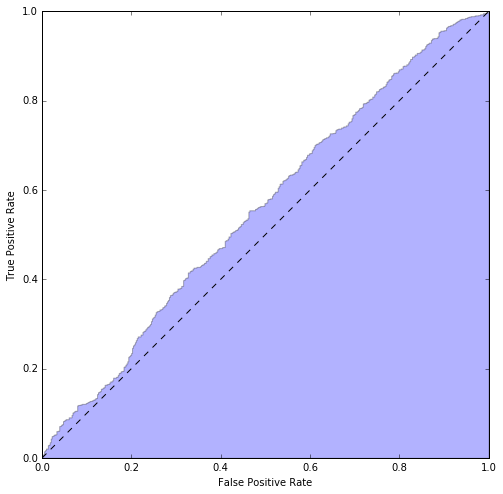

In [432]:
def classify(X, Y, test_size, C):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    Y_test_prob = LogisticRegression().fit(X_train, Y_train,C).predict_proba(X_test)
    tpr, fpr, roc_auc = roc_cur_points(Y_test_prob,Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[1])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    # Your code here
    plt.figure(figsize=(8, 8))
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [442]:
test_users = df_users_ex["uid"].values
ix2 = np.in1d(users, test_users).reshape(users.shape)
X2 = X_dataset[np.where(ix2)]
X3 = X2.tocsc()[:, features_counts > 100].toarray()

In [444]:
y_example = LogisticRegression().fit(X1, Y, C[1]).predict_proba(X3)

Finished studing, made 7 steps


In [520]:
b = pd.DataFrame()
b["uid"] = test_users
b["cls"] = y_example
b.to_csv("My_Submission.csv",index = False)